In [1]:
import jax 
import jax.numpy as jnp

from experiments.plotting import load_checkpoint_w_batch_stats, load_checkpoint_wo_batch_stats

x0 = [0.1, 0.1]
y = [1.5, 0.2]
T = 2.0
N = 50

In [2]:
import src.models
from src.training import train_utils
import orbax.checkpoint


def mean_and_std(trajs):
    mean = jnp.mean(trajs, axis=0)
    std = jnp.std(trajs, axis=0)
    return mean, std


def plot_mean_and_std(mean, std, ts, ax, fig, axs):
    axs.plot(ts, mean[:, ax])
    axs.fill_between(ts, mean[:, ax] - std[:, ax], mean[:, ax] + std[:, ax], alpha=0.5)
    return fig, axs


Load unconditioned trajectories

In [3]:
from src.sdes import sde_cell_model, sde_utils

fw_N = 500
data_fn  = sde_cell_model.data_forward(x0, T, fw_N)
keys = jax.random.split(jax.random.PRNGKey(10), 1000)

ts_mult, forward_trajs, _ = data_fn(keys)
ts = ts_mult[0, :, 0]

(500,)
(1000, 500, 2)


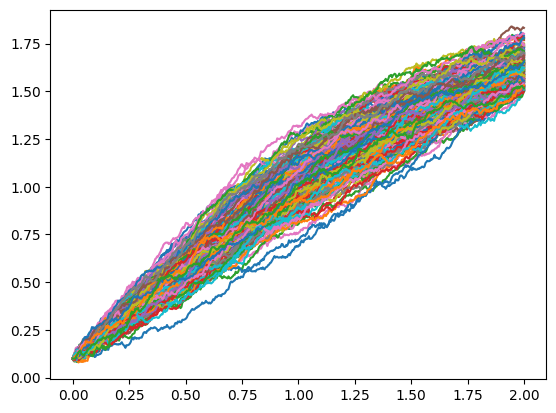

In [4]:
import matplotlib.pyplot as plt

print(ts.shape)
print(forward_trajs.shape)

for traj in forward_trajs:
    if traj[-1, 0] > 1.5 and -1.0 < traj[-1, 1] < 0.7:
        plt.plot(ts, traj[:, 0])
        # plt.plot(ts, traj[:, 1])
    if traj[-1, 1] > 1.5 and -1.0 < traj[-1, 0] < 0.7:
        plt.plot(ts, traj[:, 1])
        # plt.plot(ts, traj[:, 0])
plt.show()


Load conditioned trajectories from proposed model

In [5]:
path = f"../../checkpoints/cell/fixed_y_{y}_T_{T}_N_50"

N=50

ts_cond = jnp.linspace(0, T, N)

trained_score, restored = load_checkpoint_w_batch_stats(path)

def conditioned_fn(key):
    drift, diffusion = sde_cell_model.vector_fields()
    traj = sde_utils.conditioned(key, ts_cond, x0, trained_score, drift, diffusion)
    return traj


keys = jax.random.split(jax.random.PRNGKey(20), 1000)
conditioned_trajs = jax.vmap(conditioned_fn)(keys)

print(restored["network"])

{'activation': 'leaky_relu', 'decoder_layer_dims': [128, 128], 'encoder_layer_dims': [16], 'init_embedding_dim': 16, 'output_dim': 2, 'time_embedding_dim': 32}


In [6]:
print(restored["training"])

{'batch_size': 100, 'epochs_per_load': 1, 'load_size': 10000, 'lr': 0.01, 'num_reloads': 100}


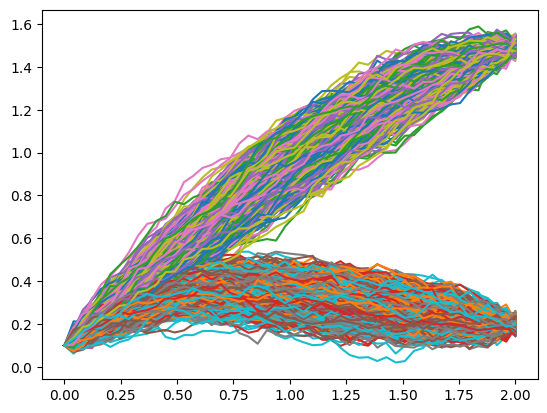

In [7]:
import matplotlib.pyplot as plt

for traj in conditioned_trajs:
    plt.plot(ts_cond, traj[:, 0])
    plt.plot(ts_cond, traj[:, 1])
plt.show()

Load time reversed trajectories from diffusion bridge

In [8]:
import numpy as np

diffusion_bridge_fw = np.load("/Users/libbybaker/Documents/Python/DiffusionBridge/cell/cell_traj_T_2.0_X0_tensor([0.1000, 0.1000])_XT_tensor([1.5000, 0.2000])_M_50_50.npy")

time_steps = diffusion_bridge_fw.shape[1]
ts_fw = np.linspace(0, T, time_steps)

In [9]:
import numpy as np

diffusion_bridge_bw = np.load("/Users/libbybaker/Documents/Python/DiffusionBridge/cell/cell_traj_T_2.0_X0_tensor([0.1000, 0.1000])_XT_tensor([1.5000, 0.2000])_M_50_bw.npy")

time_steps = diffusion_bridge_bw.shape[1]
ts_bw = np.linspace(0, T, time_steps)

Load trajectories from guided MH

In [10]:
import pandas as pd
import jax.numpy as jnp
import numpy as np

# Load the CSV file into a pandas DataFrame
df = pd.read_csv('/Users/libbybaker/Documents/Bridge.jl/example/cell_model_runs/cell_T_2_x_0.1_y_[1.5, 0.2].csv')
# df = pd.read_csv('/Users/libbybaker/Documents/Bridge.jl/example/cell_model_runs/iterates.csv')


iterations = []
for i in range(2000):
    iteration = df[df['iteration'] == i]
    vals = iteration['value'].values
    vals = np.reshape(vals, (-1, 2))
    if len(vals) > 0:
        iterations.append(vals)
    
guided_traj = jnp.asarray(iterations)
time_steps = guided_traj.shape[1]
ts_gt = np.linspace(0, T, time_steps)

Plot everything

In [11]:
import matplotlib.pyplot as plt
from tueplots import bundles, axes, cycler, figsizes
from tueplots.constants.color import palettes

bundle = bundles.neurips2023()
plt.rcParams.update(bundle)
plt.rcParams.update(cycler.cycler(color=palettes.paultol_muted))
plt.rcParams.update(axes.lines())


def plot_trajectories(trajs, ts, axis, axs, color, **plot_kwargs):
    for traj in trajs:
        axs.plot(ts, traj[:, axis], color=color, **plot_kwargs)
    return axs

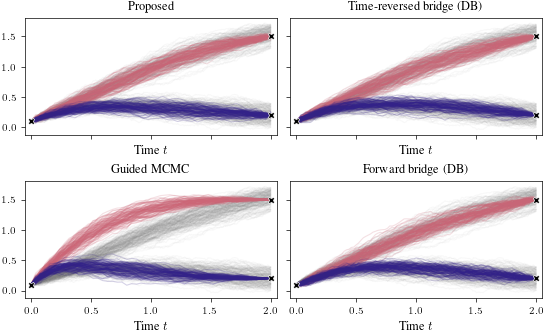

In [12]:
plt.rcParams.update(figsizes.neurips2023(nrows=2, ncols=2))

fig, axs = plt.subplot_mosaic([["proposed", "forward"], ["guided", "backward"]], sharex=True, sharey=True)

upper_max = 1.7
upper_min = 1.3
lower_max = 0.4
lower_min = 0.0

plot_kwargs_true = {"linewidth": 0.8, "alpha": 0.05}
plot_kwargs = {"linewidth": 0.8, "alpha": 0.2}

for ax in axs["proposed"], axs["guided"], axs["forward"], axs["backward"]:
    
    for traj in forward_trajs:
        if upper_max > traj[-1, 0] > upper_min and lower_min < traj[-1, 1] < lower_max:
            ax.plot(ts, traj[:, 0], color='grey', **plot_kwargs_true)
            ax.plot(ts, traj[:, 1], color='grey', **plot_kwargs_true)
        # if traj[-1, 1] > upper_min and lower_min < traj[-1, 0] < lower_max:
        #     ax.plot(ts, traj[:, 1], color='grey', **plot_kwargs_true)
        #     ax.plot(ts, traj[:, 0], color='grey', **plot_kwargs_true)
            
    ax.set_xlim(-0.05, 2.05)
    ax.set_xlabel("Time $t$")
    ax.plot([0, 2, 2], [0.1, 1.5, 0.2], marker="X",markersize=5, markeredgewidth=0.5, linestyle="None", zorder=10, color="black", markeredgecolor="white")
  
axs["guided"] = plot_trajectories(guided_traj[:100], ts_gt, 0, axs["guided"], 'C0', **plot_kwargs)
axs["guided"] = plot_trajectories(guided_traj[:100], ts_gt, 1, axs["guided"], 'C1', **plot_kwargs)
axs["guided"].set_title("Guided MCMC")


axs["forward"] = plot_trajectories(diffusion_bridge_fw[:100], ts_fw, 0, axs["forward"], 'C0', **plot_kwargs)
axs["forward"] = plot_trajectories(diffusion_bridge_fw[:100], ts_fw, 1, axs["forward"], 'C1', **plot_kwargs)
axs["forward"].set_title("Time-reversed bridge (DB)")


axs["proposed"] = plot_trajectories(conditioned_trajs[:100], ts_cond, 0, axs["proposed"], 'C0', **plot_kwargs)
axs["proposed"] = plot_trajectories(conditioned_trajs[:100], ts_cond, 1, axs["proposed"], 'C1', **plot_kwargs)
axs["proposed"].set_title("Proposed")

axs["backward"] = plot_trajectories(diffusion_bridge_bw[:100], ts_bw, 0, axs["backward"], 'C0', **plot_kwargs)
axs["backward"] = plot_trajectories(diffusion_bridge_bw[:100], ts_bw, 1, axs["backward"], 'C1', **plot_kwargs)
axs["backward"].set_title("Forward bridge (DB)")


plt.savefig("cell_comparison.pdf")
# fig, axs = plot_trajectories(diffusion_bridge_fw, ts_gt, 0, fig, axs, 'C2', alpha=0.5)